## 1. Find the camera matrix and distortion Co-efficients

In [1]:
# import essential modules
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

In [2]:
import os

path_calibration = "camera_cal/"
calibration_images = os.listdir(path_calibration)

obj_point_list = []
img_point_list = []

#Getting Objectpoints 
obj_points = np.zeros((9*6,3), np.float32)
obj_points[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
#iterating through all images in the folder 
for image in calibration_images:
    # generate the actual path of the image
    img_path = os.path.join(path_calibration, image)
    img = mpimg.imread(img_path)
    # convert the image to gray scale as the findChessboardCorners takes only gray scale images
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
    if ret:
        obj_point_list.append(obj_points)
        img_point_list.append(corners)

# get the camera matrix and distorted matrix
ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(obj_point_list, img_point_list, gray.shape[::-1], None, None)



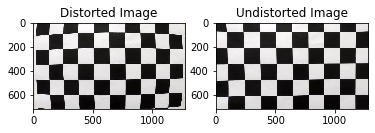

In [3]:
%matplotlib inline
img_path = os.path.join(path_calibration, "calibration1.jpg")
img = mpimg.imread(img_path)
plt.subplot(121)
plt.title("Distorted Image")
plt.imshow(img)
undistort = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(122)
plt.title("Undistorted Image")
plt.imshow(undistort)

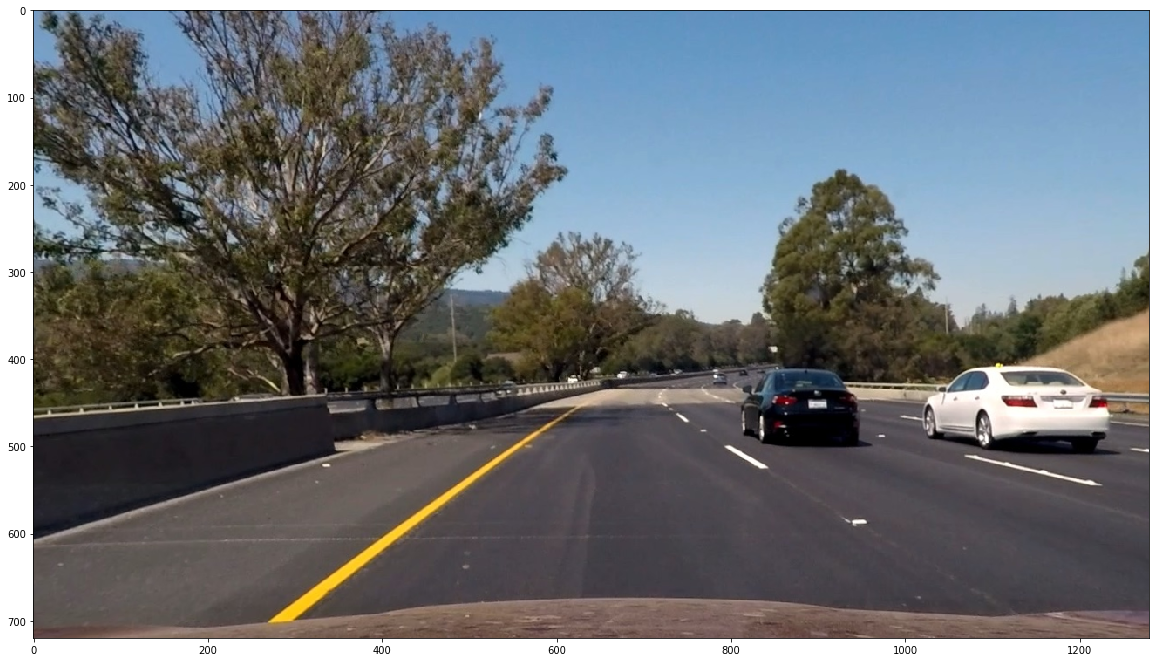

In [4]:
img_path = "test_images/test6.jpg"
# img_path = "test_images/straight_lines2.jpg"
img = mpimg.imread(img_path)
plt.figure(figsize=(20,20))
plt.imshow(img)
undistorted_original = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undistorted_original)

1


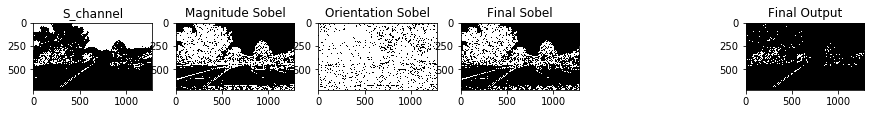

In [5]:
# Color Thresholding
plt.figure(figsize=(20,20))

s_high = 250
s_low = 90
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]
binary = np.zeros_like(s_channel)

binary[(s_channel>=s_low)&(s_channel<=s_high)] = 1
print(np.max(binary))
plt.subplot(181)
plt.title("S_channel")
plt.imshow(binary,cmap='gray')



#Magnitude Thresholding
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, ksize=3)
absolute_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
scaled_sobel = np.uint8(255 * absolute_sobel/ np.max(absolute_sobel))
binary_scaled = np.zeros_like(scaled_sobel)
binary_scaled[(scaled_sobel >= 10) & (scaled_sobel <= 150)] = 1
plt.subplot(182)
plt.title("Magnitude Sobel")
plt.imshow(binary_scaled,cmap='gray')


#Direction threholding
orientation = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
# scaled_orientation = np.uint8(255 * orientation / np.max(orientation))
binary_orient = np.zeros_like(orientation)
binary_orient[(orientation >= 0) & (orientation <= 1.5)] = 1
plt.subplot(183)
plt.title("Orientation Sobel")
plt.imshow(binary_orient, cmap='gray')

combined = np.zeros_like(binary_orient)
combined[(binary_orient == 1) & (binary_scaled == 1)] =1
plt.subplot(184)
plt.title("Final Sobel")
plt.imshow(combined, cmap='gray')


color_gradient = np.zeros_like(combined)
color_gradient[(combined == 1) & (binary ==1)] =1
plt.subplot(186)
plt.title("Final Output")
plt.imshow(color_gradient, cmap='gray')

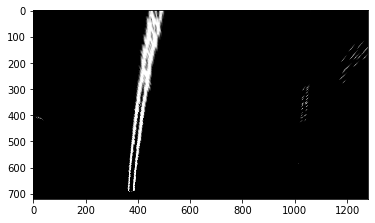

In [6]:
img = color_gradient
# h,w,_ = img.shape
h,w = img.shape

midpoint = w // 2
offset_midpoint = 130

height_low = h //2 + 115
height_hight = h - 50

offset = 50

src = np.array([[midpoint-offset_midpoint, height_low],[midpoint+offset_midpoint, height_low],
                [midpoint+4.2*offset_midpoint, height_hight],[midpoint-4.2*offset_midpoint, height_hight]], np.float32)
# dst = np.array([[offset, offset],[w-offset, offset],
#                 [w-offset, h-offset],[offset, h-offset]], np.float32)

dst = np.array([[midpoint-3.7*offset_midpoint, offset],[midpoint+3.7*offset_midpoint, offset],
                [midpoint+3.5*offset_midpoint, height_hight],[midpoint-3.5*offset_midpoint, height_hight]], np.float32)

undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
# print(src)
# plt.scatter(midpoint-offset_midpoint, height_low, color='red')
# plt.scatter(midpoint+offset_midpoint, height_low, color='green')
# plt.scatter(midpoint+4.2*offset_midpoint, height_hight, color='white')
# plt.scatter(midpoint-4.2*offset_midpoint, height_hight, color='blue')

# plt.scatter(midpoint-4.2*offset_midpoint, offset, color='red')
# plt.scatter(midpoint+4*offset_midpoint, offset, color='green')
# plt.scatter(midpoint+4.2*offset_midpoint, height_hight, color='white')
# plt.scatter(midpoint-4.2*offset_midpoint, height_hight, color='blue')

# plt.imshow(undistort_img, cmap='gray')
M = cv2.getPerspectiveTransform(src,dst)
warp_img = cv2.warpPerspective(undistort_img, M, (w,h), cv2.INTER_LINEAR)
plt.imshow(warp_img, cmap='gray')

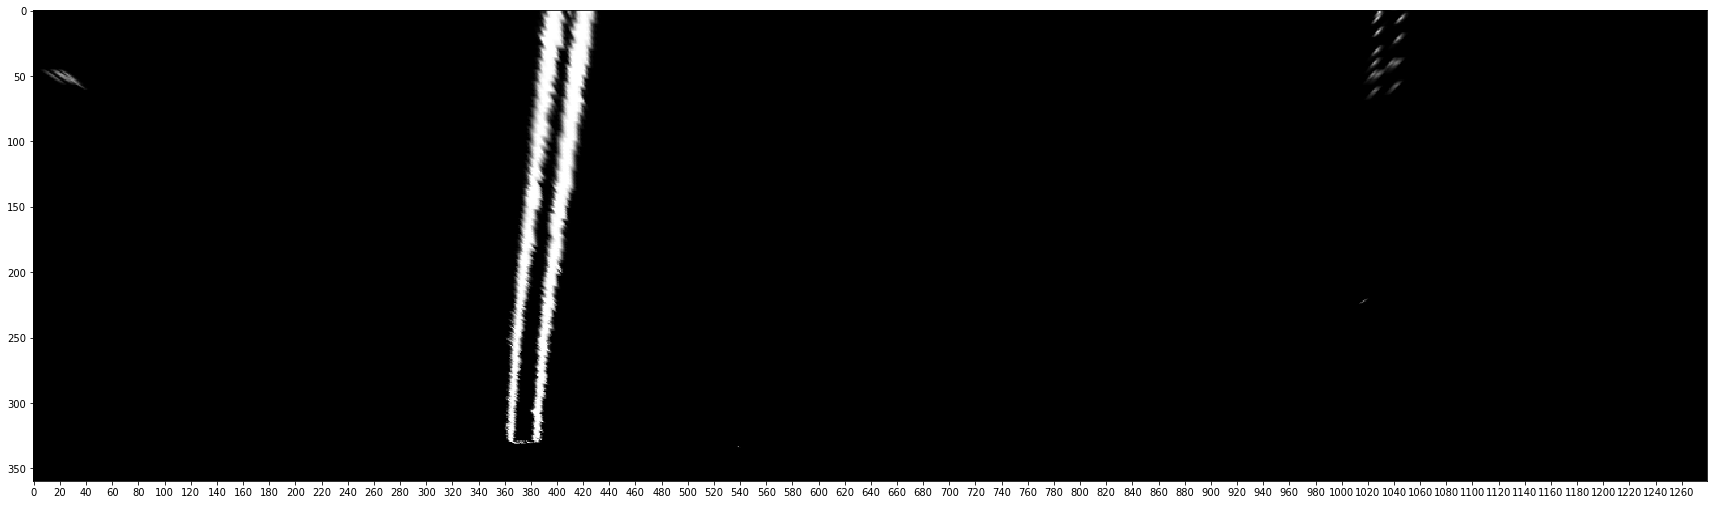

In [7]:
img = warp_img
hist = np.sum(img[img.shape[0]//2:, :], axis=0)

midpoint = len(hist) // 2
left_current = np.argmax(hist[: midpoint])
right_current = np.argmax(hist[midpoint :]) + midpoint


plt.figure(figsize=(30,30))
plt.xticks(np.arange(0, 1280, step=20)) 
plt.imshow(img[img.shape[0]//2:, :],cmap='gray')

In [8]:
nwindows = 20
minpiixels = 50
margin = 100
height, width = img.shape
nonzero = np.nonzero(img)
nonzerox = nonzero[1]
nonzeroy = nonzero[0]
# print(len(nonzerox), len(nonzeroy))
left_inds = []
right_inds = []
window_height = height // nwindows
for i in range(nwindows):
    win_height_high = height - i*window_height
    win_height_low = height - (i+1)*window_height
    
    win_left_min = left_current - margin
    win_left_max = left_current + margin
    win_right_min = right_current - margin
    win_right_max = right_current + margin
#     print("Win Height[{}, {}], left Wind[{},{}], Right Wind[{},{}]"
#           .format(win_height_low, win_height_high, win_left_min, win_left_max,
#                  win_right_min, win_right_max))
    
    left_current_inds = ((nonzeroy >= win_height_low)&(nonzeroy <= win_height_high)&
                         (nonzerox >= win_left_min)&(nonzerox <= win_left_max)).nonzero()[0]
    right_current_inds = ((nonzeroy >= win_height_low)&(nonzeroy <= win_height_high)&
                         (nonzerox >= win_right_min)&(nonzerox <= win_right_max)).nonzero()[0]
    
#     print(len(left_current_inds), len(right_current_inds))
#     print(left_current_inds.shape, right_current_inds.shape)
    left_inds.append(left_current_inds)
    right_inds.append(right_current_inds)
    
    if len(left_current_inds) > minpiixels:
        left_current =  int(np.mean(nonzerox[left_current_inds]))
    if len(right_current_inds) > minpiixels:
        right_current =  int(np.mean(nonzerox[right_current_inds]))

left_inds = np.concatenate(left_inds)
right_inds = np.concatenate(right_inds)

        
left_x = nonzerox[left_inds]
left_y = nonzeroy[left_inds]
right_x = nonzerox[right_inds]
right_y = nonzeroy[right_inds]

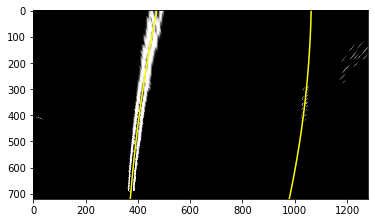

In [9]:
left_fit = np.polyfit(left_y, left_x, 2)
right_fit = np.polyfit(right_y, right_x, 2)

ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
left_fitx = left_fit[0]*(ploty**2) + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*(ploty**2) + right_fit[1]*ploty + right_fit[2]


# Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(img, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


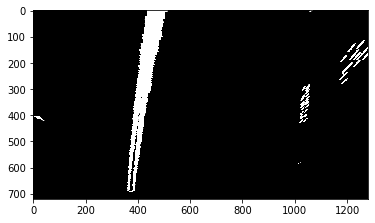

In [10]:
img_warp = warp_img
out_img = np.dstack((img_warp, img_warp, img_warp)) *255

window_img = np.zeros_like(out_img)
plt.imshow(out_img, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


float64


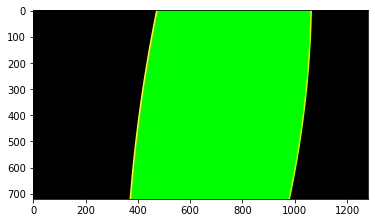

In [12]:
img_warp = warp_img
out_img = np.dstack((img_warp, img_warp, img_warp)) *255

window_img = np.zeros_like(out_img)
# plt.imshow(out_img, cmap='gray')


left_line_points = np.array([np.vstack((left_fitx, ploty)).T])
right_line_points = np.array([np.flipud(np.vstack((right_fitx, ploty)).T)])
lane_pts = np.hstack((left_line_points, right_line_points))

cv2.fillPoly(window_img, np.int_([lane_pts]), (0,255,0))

result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
print(out_img.dtype)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(window_img)

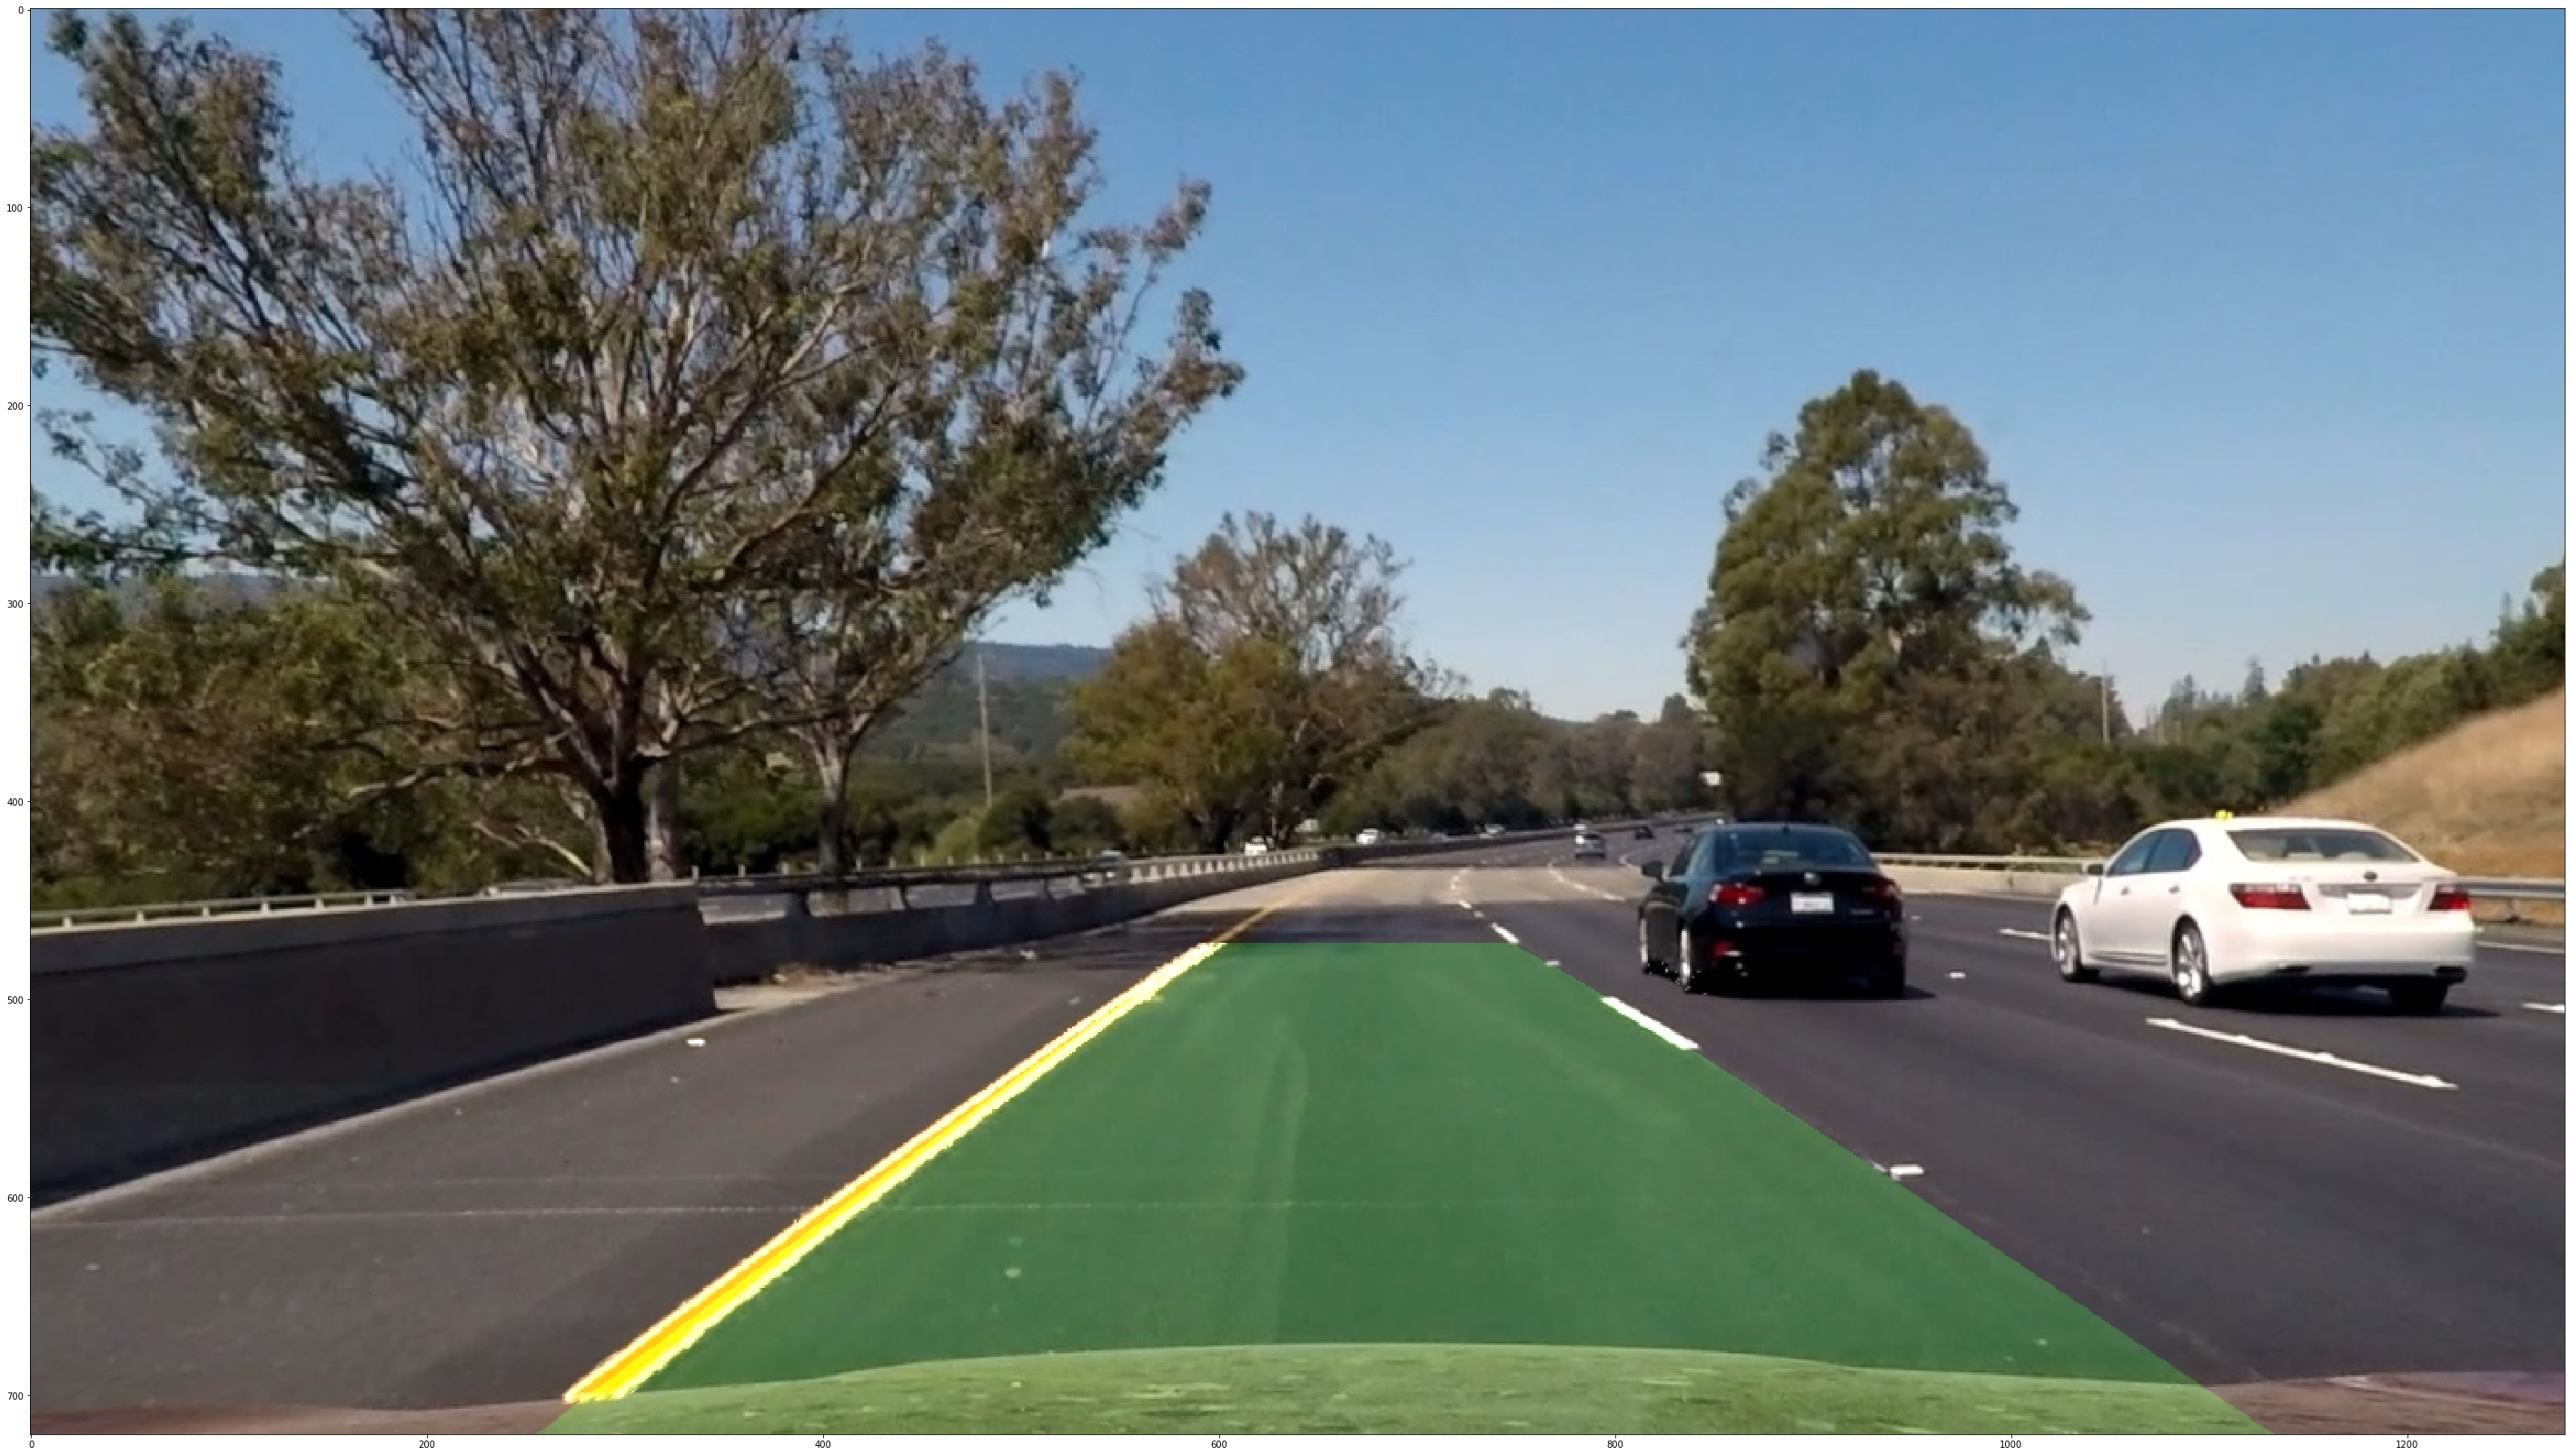

In [13]:
M_inv = cv2.getPerspectiveTransform(dst,src)
un_warp_img = cv2.warpPerspective(result, M_inv, (w,h))


# Due to the changes in Format in original image and unwarp image, we need to normalize the values
img_n = cv2.normalize(src=un_warp_img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

actual_image_region = cv2.addWeighted(undistorted_original, 1, img_n , 0.8,0)
plt.figure(figsize=(50,50))
plt.imshow(actual_image_region)